In [1]:
import torch
import numpy as np
import math
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
if train_on_gpu:
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2070 SUPER


In [13]:
import matplotlib.pyplot as plt

In [2]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
def class_acc(pred, gt):
    true = 0

    for labels in zip(pred, gt):
        if labels[0] == labels[1]:
            true += 1

    return (true/len(gt))*100

# Loading Data through PyTorch builtin function

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

#load data and also transform it to pytorch tensor so that can be used on model
transform = transforms.Compose([
    transforms.ToTensor()
    ])

#Folder should be in form ./data/cifar-10-batches-py/<all data batches here>

Cfar_10_train = datasets.CIFAR10('./data/',train=True,transform=transform)
Cfar_10_test = datasets.CIFAR10('./data/',train=False,transform=transform)
train_data = torch.utils.data.DataLoader(Cfar_10_train,
                                          batch_size=64,
                                          shuffle=True)

test_data = torch.utils.data.DataLoader(Cfar_10_test,
                                          batch_size=10,
                                          shuffle=True)



# Defining model

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        # convolutional layer (sees 3 x32x32 image tensor) (RGB x W x H)
        self.conv1 = nn.Conv2d(3, 96, 3, padding=1, stride=1)
        # convolutional layer (sees 96 x16x16 tensor)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1,stride=2)
        # convolutional layer (sees 96 x8x8 tensor)
        self.conv3 = nn.Conv2d(96, 192, 3, padding=1,stride=1)
        # convolutional layer (sees 192 x4x4 tensor)
        self.conv4 = nn.Conv2d(192, 192, 3, padding=1,stride=2)
        
        # linear layer (192 * 2 *2 -> 768)
        self.fc1 = nn.Linear(192 * 2 * 2, 500)
        # linear layer (500 -> 256)
        self.fc2 = nn.Linear(500, 256)
        # linear layer (256 -> 10)
        self.drop1 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 10)
        

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        
        x = F.relu(self.conv2(x))
        
        x = self.pool(F.relu(self.conv3(x)))
        
        x = F.relu(self.conv4(x))
        
        # flatten image input
        x = x.view(-1, 192 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x=self.drop1(x)
        x = torch.sigmoid(self.fc3(x))
        return x


model = Net()
print(model)


if train_on_gpu:
    model.cuda()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=768, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [6]:
#testing model output for dimensions
output = model(torch.Tensor(np.empty((1,3,32,32))).cuda().float())

print(output.shape)

torch.Size([1, 10])


In [7]:
import torch.optim as optim

loss_function = nn.BCELoss()

#stochastic gradient descent for optimzing loss function
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training


In [8]:
test_min = math.inf
lossT=[]
epoch=[]
for epochs in range(1,50):
    
    training_loss = 0
    testing_loss=0
    model.train()
    
    #data in form (batch_size, RGB, H,W), label in form (Batch_size,1)
    for data, label in train_data:
        label = F.one_hot(label,num_classes=10)
        if train_on_gpu:
            data, label = data.cuda(), label.cuda().float()
            
        optimizer.zero_grad()
        
        #output = (batch_size,10)
        output = model(data)
        loss = loss_function(output,label)
        loss.backward()
        optimizer.step()
        
        #total loss over a batch
        training_loss+=loss.item()*data.size(0)
    
    #average training loss over 1 epoch
    training_loss=training_loss/len(train_data.dataset)    
    lossT.append(training_loss)
    epoch.append(epochs)
    print('Epoch: {} \tTraining Loss: {}'.format(epochs,training_loss))
    model.eval()
    total_correct = 0
    for data_t, label_t in test_data:
        label_t = F.one_hot(label_t,num_classes=10)
        if train_on_gpu:
            data_t, label_t = data_t.cuda(), label_t.cuda().float()
        
        output_t = model(data_t)
        loss = loss_function(output_t,label_t)
        testing_loss+=loss.item()*data.size(0)
        
#         for idx, pred in enumerate(output_t.max(1).indices):
# #             print("Predicted: ",classes[pred])
# #             print("actually: ",classes[label_t[idx].argmax()])
#             if label_t[idx][pred]:
                
#                 total_correct+=1

    testing_loss=testing_loss/len(test_data.dataset)
    print('Epoch: {} \tTesting Loss: {}'.format(epochs,testing_loss))
    if testing_loss<test_min:
        test_min=testing_loss
        torch.save(model.state_dict(), './models/model+epoch{}.pth'.format(epochs))
        print("Saving model as testing loss decreased")
    
    
        
    
    
    

Epoch: 1 	Training Loss: 0.36131979969978334
Epoch: 1 	Testing Loss: 0.5215864757537841
Saving model as testing loss decreased
Epoch: 2 	Training Loss: 0.32629025355339053
Epoch: 2 	Testing Loss: 0.5198815326213837
Saving model as testing loss decreased
Epoch: 3 	Training Loss: 0.3253344324016571
Epoch: 3 	Testing Loss: 0.5171931965351104
Saving model as testing loss decreased
Epoch: 4 	Training Loss: 0.3154613423538208
Epoch: 4 	Testing Loss: 0.5034890913009643
Saving model as testing loss decreased
Epoch: 5 	Training Loss: 0.2968469530773163
Epoch: 5 	Testing Loss: 0.4682582497358322
Saving model as testing loss decreased
Epoch: 6 	Training Loss: 0.2889463156223297
Epoch: 6 	Testing Loss: 0.46233075535297397
Saving model as testing loss decreased
Epoch: 7 	Training Loss: 0.28042924783706663
Epoch: 7 	Testing Loss: 0.4600528417825699
Saving model as testing loss decreased
Epoch: 8 	Training Loss: 0.2690238276576996
Epoch: 8 	Testing Loss: 0.4172309596061707
Saving model as testing los

# Loading best model and testing on test set

In [12]:
model.load_state_dict(torch.load('./models/model+epoch41.pth'))
model.eval()
total_correct = 0
for data_t, label_t in test_data:
        label_t = F.one_hot(label_t,num_classes=10)
        if train_on_gpu:
            data_t, label_t = data_t.cuda(), label_t.cuda().float()
        
        output_t = model(data_t)
        loss = loss_function(output_t,label_t)
        testing_loss+=loss.item()*data.size(0)
        
        for idx, pred in enumerate(output_t.max(1).indices):
            
#             print("Predicted: ",classes[pred])
#             print("actually: ",classes[label_t[idx].argmax()])
            if label_t[idx][pred]:
                
                total_correct+=1
print('Accuracy over Test set {}'.format(total_correct/len(test_data.dataset)*100))

Accuracy over Test set 71.6


# Training Loss vs epochs

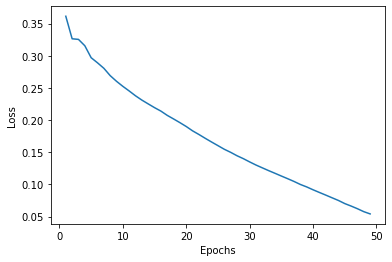

In [14]:
plt.plot(epoch, lossT)

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()